In [1]:
import numpy as np
from scipy import optimize
import itertools
import math
import random
import matplotlib.pyplot as plt

In [2]:
def two_opt(a,eps):
    c = math.exp(eps[0]); d = math.exp(eps[1])
    if c*d >= (a[0]-1)*(a[1]-1) and a[1]*c-a[0]*d+a[0]-a[1] >= 0:
        s0 = (a[1]*c*d+(a[0]-1)*(a[1]-1)*d-(a[0]-1)*(a[1]-1))/(d+a[1]-1)
        s1 = 1
        s2 = (a[1]*c-(a[0]-1)*d+a[0]-1)/(d+a[1]-1)
    elif c*d >= (a[0]-1)*(a[1]-1) and a[1]*c-a[0]*d+a[0]-a[1] < 0:
        s0 = (a[0]*c*d+(a[0]-1)*(a[1]-1)*c-(a[0]-1)*(a[1]-1))/(c+a[0]-1)
        s1 = (-(a[1]-1)*c+a[0]*d+a[1]-1)/(c+a[0]-1)
        s2 = 1
    elif c*d < (a[0]-1)*(a[1]-1) and (a[0]-a[1])*c*d+a[0]*(a[1]-1)*c-(a[0]-1)*a[1]*d >= 0:
        s0 = ((a[0]-1)*c*(d+a[1]-1))/(-c*d+c+(a[0]-1)*a[1])
        s1 = ((a[1]-1)*c*d-(a[1]-1)*c+(a[0]-1)*a[1]*d)/(-c*d+c+(a[0]-1)*a[1])
        s2 = ((a[0]-1)*c*(d+a[1]-1))/(-c*d+c+(a[0]-1)*a[1])
    else:
        s0 = ((a[1]-1)*d*(c+a[0]-1))/(-c*d+d+a[0]*(a[1]-1))
        s1 = ((a[1]-1)*d*(c+a[0]-1))/(-c*d+d+a[0]*(a[1]-1))
        s2 = ((a[0]-1)*c*d+a[0]*(a[1]-1)*c-(a[0]-1)*d)/(-c*d+d+a[0]*(a[1]-1))
    s3 = 1
    return s0,s1,s2

def k_inductive(k,a,eps):
    x = np.zeros((k+1,k+1))
    x[2][0],x[2][1],x[2][2] = two_opt([a[0],a[1]],[eps[0],eps[1]])
    s = a[0]; p = a[0]
    for i in range(3,k+1):
        for j in range(1,i):
            x[i][j] = a[i-1]*x[i-1][j]-a[i-1]+1
        s += a[i-2]; p *= a[i-2]
        s0 = 0
        for j in range(1,i):
            s0 += (a[j-1]-1)*x[i][j]
        left = [[1,a[i-1]-1], [1,-math.exp(eps[i-1])]]
        right = [a[i-1]*x[i-1][0], -s0-p+s-i+2+math.exp(eps[i-1])*(p-1)]
        x[i][0],x[i][i] = np.linalg.solve(left,right)
        f = 0
        if x[i][0] < 1 or x[i][i] < 1:
            f = 1
        for j in range(1,i+1):
            if x[i][0] < x[i][j]:
                f = 1; break
        if f == 1:
            x[i][0] = a[i-1]*x[i-1][0]-a[i-1]+1
            x[i][i] = 1
            eps[i-1] = math.log((x[i][0]+s0+p-s+i-2)/(x[i][i]+p-1))
            
    return x[k],eps

In [3]:
def dataset(N,t):
    a = np.zeros(t); b = np.zeros(t); c = np.zeros(t); d = np.zeros(t)
    
    for i in range(t):
        a[i] = np.random.binomial(N,1/3)
        b[i] = np.random.binomial(N-a[i],1/3)
        c[i] = np.random.binomial(N-a[i]-b[i],2/5)
        d[i] = N-a[i]-b[i]-c[i]
    
    return a,b,c,d

In [4]:
def RR(eps,a,b,c,d,N,t):
    g = np.zeros(N); gRR = np.zeros(N)
    for i in range(t):
        k = 0
        for j in range(int(a[i])):
            g[k] = 1; k += 1
        for j in range(int(b[i])):
            g[k] = 2; k += 1
        for j in range(int(c[i])):
            g[k] = 3; k += 1
        for j in range(int(d[i])):
            g[k] = 4; k += 1
    aRR = np.zeros(t); bRR = np.zeros(t); cRR = np.zeros(t); dRR = np.zeros(t)
    for i in range(t):
        for j in range(N):
            rand = random.random()
            if rand >= 4/(math.exp(eps[i])+3):
                gRR[j] = g[j]
            else:
                gRR[j] = random.randint(1,4)
            if gRR[j] == 1:
                aRR[i] += 1
            elif gRR[j] == 2:
                bRR[i] += 1
            elif gRR[j] == 3:
                cRR[i] += 1
            else:
                dRR[i] += 1
    return aRR, bRR, cRR, dRR

def chi2(a,b,c,d,N):
    return (N*(a*d - b*c)**2)/((a+b)*(c+d)*(a+c)*(b+d))

def evaluation(t,N):
    eps = np.zeros(t); Kro_eps = np.zeros(t)
    
    for i in range(t):
        eps[i] = random.uniform(3,5)
    h_ans,eps = k_inductive(t,4*np.ones(t),eps)
    s = np.sum(eps)
    p = math.log(h_ans[0])
    for i in range(t):
        Kro_eps[i] = (p*eps[i])/s
    
    #print(eps[0])
    #print(Kro_eps[0])
    
    a,b,c,d = dataset(N,t)
    stats = np.zeros(t); statsRR = np.zeros(t); Kro_statsRR = np.zeros(t)
    aRR,bRR,cRR,dRR = RR(eps,a,b,c,d,N,t); Kro_aRR, Kro_bRR, Kro_cRR, Kro_dRR = RR(Kro_eps,a,b,c,d,N,t)
    diffRR = 0; Kro_diffRR = 0
    for i in range(t):
        stats[i] = chi2(a[i],b[i],c[i],d[i],N)
        statsRR[i] = chi2(aRR[i],bRR[i],cRR[i],dRR[i],N)
        diffRR += math.fabs(stats[i]-statsRR[i])
        Kro_statsRR[i] = chi2(Kro_aRR[i],Kro_bRR[i],Kro_cRR[i],Kro_dRR[i],N)
        Kro_diffRR += math.fabs(stats[i]-Kro_statsRR[i])
    
    return diffRR/t, Kro_diffRR/t

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[18.35706657 56.27162423]
 [17.78540755 62.23359041]
 [21.32040032 62.4992264 ]
 [19.41185744 59.14818917]
 [23.75890504 65.13521322]
 [22.77557163 64.91683838]
 [18.92138263 63.13426372]
 [16.72297185 61.85133464]
 [19.47710744 65.51420658]
 [21.78893775 65.72320964]]


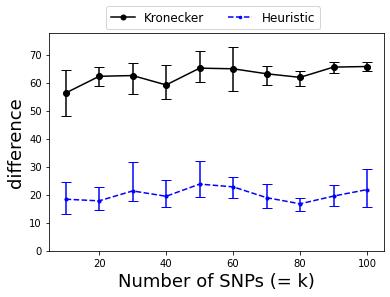

In [5]:
# k = 10 ~ 100, n = 1000

diff = np.zeros((10,2))
max_diff = np.zeros((10,2)); min_diff = 10000*np.ones((10,2))
sum_diff = np.zeros((10,2))

N = 2000
y_err = np.zeros((2,10,3))

for j in range(5):
    for i in range(10):
        diff[i][0], diff[i][1] = evaluation(10*(i+1),N)
        for k in range(2):
            if diff[i][k] > max_diff[i][k]:
                max_diff[i][k] = diff[i][k]
            if diff[i][k] < min_diff[i][k]:
                min_diff[i][k] = diff[i][k]
            sum_diff[i][k] += diff[i][k]
diff = sum_diff/5

for k in range(2):
    y_err[0,:,k] = diff[:,k] - min_diff[:,k]
    y_err[1,:,k] = max_diff[:,k] - diff[:,k]

t = np.zeros(10)
for i in range(10):
    t[i] = 10*(i+1)
print(diff)
fig = plt.figure()
plt.ylim(-0.05, np.max(max_diff)+5)
plt.xlim(5, 105)
plt.errorbar(t, diff[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(t, diff[:,1], marker="o", markersize=5, color = "black", linestyle = "-", label = "Kronecker")
plt.errorbar(t, diff[:,0], yerr = y_err[:,:,0], capsize=5, fmt='.', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(t, diff[:,0], marker=".", markersize=5, color = "blue", linestyle = "--", label = "Heuristic")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("Number of SNPs (= k)", fontsize = 18)
plt.ylabel("difference", fontsize = 18)
fig.savefig("Diff_stats.png")
fig.savefig("figs/Diff_stats.eps")